# Import packages

In [1]:
from utils import *

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

import warnings
warnings.filterwarnings(action='ignore')
# action='default'

Using TensorFlow backend.


# Define some functions

In [2]:
def shuffle_in_unison(a, b):
    # courtesy http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

def remove_nan_examples(data):
    newX = []
    for i in range(len(data)):
        if np.isnan(data[i]).any() == False:
            newX.append(data[i])
    return newX

# Load Dataset

In [3]:
data_original = pd.read_csv('./AAPL1216.csv')[::-1]

print(len(data_original))

openp = data_original['Open'].tolist()
highp = data_original['High'].tolist()
lowp = data_original['Low'].tolist()
closep = data_original['Adj Close'].tolist()
volumep = data_original['Volume'].tolist()

1006


# Preprocessing

In [4]:
WINDOW = 30
EMB_SIZE = 5
STEP = 1
FORECAST = 1

X, Y = [], []
#normalize every dimension of time window independently
for i in range(0, len(data_original), STEP): 
    try:
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]

        o = (np.array(o) - np.mean(o)) / np.std(o)
        h = (np.array(h) - np.mean(h)) / np.std(h)
        l = (np.array(l) - np.mean(l)) / np.std(l)
        c = (np.array(c) - np.mean(c)) / np.std(c)
        v = (np.array(v) - np.mean(v)) / np.std(v)

        x_i = closep[i:i+WINDOW]
        y_i = closep[i+WINDOW+FORECAST]  

        #다음날의 주가의 오름 혹은 내림을 예측하고 싶기 때문에 단일 디멘젼에서의 변화를 classify 
        last_close = x_i[-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

        x_i = np.column_stack((o, h, l, c, v))

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

# Split dataset

In [5]:
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

# Make a model

In [6]:
model = Sequential()
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        nb_filter=32,
                        filter_length=16,
                        border_mode='same'))
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        nb_filter=64,
                        filter_length=8,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0))

model.add(Convolution1D(nb_filter=16,
                        filter_length=4,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.75))

model.add(Dense(2))
model.add(Activation('softmax'))

# opt = Nadam(lr=0.002)
opt = RMSprop()

# Define some functions and compile model

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="lolkek.hdf5", verbose=1, save_best_only=True)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit

In [8]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 100, 
          batch_size = 512, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

model.load_weights("lolkek.hdf5")
pred = model.predict(np.array(X_test))

Train on 877 samples, validate on 98 samples
Epoch 1/100
877/877 [==============================] - 2s 3ms/step - loss: 1.2168 - accuracy: 0.5074 - val_loss: 0.6909 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.69087, saving model to lolkek.hdf5
Epoch 2/100
877/877 [==============================] - 0s 264us/step - loss: 1.0631 - accuracy: 0.5382 - val_loss: 0.6897 - val_accuracy: 0.4796

Epoch 00002: val_loss improved from 0.69087 to 0.68965, saving model to lolkek.hdf5
Epoch 3/100
877/877 [==============================] - 0s 267us/step - loss: 1.1086 - accuracy: 0.5314 - val_loss: 0.6908 - val_accuracy: 0.4796

Epoch 00003: val_loss did not improve from 0.68965
Epoch 4/100
877/877 [==============================] - 0s 266us/step - loss: 1.1361 - accuracy: 0.4983 - val_loss: 0.6884 - val_accuracy: 0.4898

Epoch 00004: val_loss improved from 0.68965 to 0.68839, saving model to lolkek.hdf5
Epoch 5/100
877/877 [==============================] - 0s 267us/step - los

877/877 [==============================] - 0s 258us/step - loss: 0.5454 - accuracy: 0.7195 - val_loss: 0.6647 - val_accuracy: 0.6122

Epoch 00040: val_loss did not improve from 0.66180
Epoch 41/100
877/877 [==============================] - 0s 264us/step - loss: 0.5629 - accuracy: 0.7195 - val_loss: 0.6722 - val_accuracy: 0.5510

Epoch 00041: val_loss did not improve from 0.66180
Epoch 42/100
877/877 [==============================] - 0s 257us/step - loss: 0.5547 - accuracy: 0.7332 - val_loss: 0.6801 - val_accuracy: 0.5714

Epoch 00042: val_loss did not improve from 0.66180
Epoch 43/100
877/877 [==============================] - 0s 266us/step - loss: 0.5397 - accuracy: 0.7206 - val_loss: 0.6720 - val_accuracy: 0.5408

Epoch 00043: val_loss did not improve from 0.66180
Epoch 44/100
877/877 [==============================] - 0s 281us/step - loss: 0.5256 - accuracy: 0.7286 - val_loss: 0.6713 - val_accuracy: 0.5612

Epoch 00044: val_loss did not improve from 0.66180
Epoch 45/100
877/877 [=

877/877 [==============================] - 0s 259us/step - loss: 0.1910 - accuracy: 0.9282 - val_loss: 0.9062 - val_accuracy: 0.5612

Epoch 00081: val_loss did not improve from 0.66180
Epoch 82/100
877/877 [==============================] - 0s 262us/step - loss: 0.1515 - accuracy: 0.9339 - val_loss: 0.9053 - val_accuracy: 0.5510

Epoch 00082: val_loss did not improve from 0.66180
Epoch 83/100
877/877 [==============================] - 0s 260us/step - loss: 0.1591 - accuracy: 0.9361 - val_loss: 0.9781 - val_accuracy: 0.5510

Epoch 00083: val_loss did not improve from 0.66180
Epoch 84/100
877/877 [==============================] - 0s 292us/step - loss: 0.1705 - accuracy: 0.9270 - val_loss: 0.9707 - val_accuracy: 0.5204

Epoch 00084: val_loss did not improve from 0.66180
Epoch 85/100
877/877 [==============================] - 0s 285us/step - loss: 0.1454 - accuracy: 0.9498 - val_loss: 0.9837 - val_accuracy: 0.5306

Epoch 00085: val_loss did not improve from 0.66180
Epoch 86/100
877/877 [=

# Load metrics packages and print confusion matrix

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

print(C / C.astype(np.float).sum(axis=1))

[[0.65306122 0.34693878]
 [0.42857143 0.57142857]]


which shows that we predict “UP” movement with 65% of accuracy and “DOWN” with 57% of accuracy

In [10]:
for i in range(len(pred)):
     print(Y_test[i], pred[i])

[1 0] [0.54814804 0.45185193]
[1 0] [0.5805569 0.419443 ]
[1 0] [0.6311349  0.36886504]
[1 0] [0.46852085 0.5314791 ]
[0 1] [0.5069786 0.4930215]
[0 1] [0.5272577  0.47274226]
[0 1] [0.5120727  0.48792726]
[0 1] [0.51611334 0.48388666]
[0 1] [0.48757216 0.51242787]
[1 0] [0.477149   0.52285093]
[1 0] [0.5235007  0.47649932]
[1 0] [0.48750144 0.51249856]
[0 1] [0.4191548 0.5808452]
[0 1] [0.43122396 0.568776  ]
[0 1] [0.52516675 0.47483325]
[1 0] [0.45844638 0.5415536 ]
[0 1] [0.4548884 0.5451116]
[1 0] [0.5275435  0.47245654]
[1 0] [0.5333877  0.46661228]
[1 0] [0.5235731 0.4764269]
[1 0] [0.5476645  0.45233554]
[1 0] [0.52305615 0.4769439 ]
[1 0] [0.48821414 0.5117859 ]
[1 0] [0.4270432 0.5729568]
[0 1] [0.3615383  0.63846165]
[0 1] [0.3599362  0.64006376]
[1 0] [0.46088144 0.5391185 ]
[0 1] [0.5968666 0.4031334]
[0 1] [0.6840435  0.31595644]
[1 0] [0.69896066 0.30103928]
[1 0] [0.5138023  0.48619768]
[0 1] [0.37935683 0.62064314]
[0 1] [0.415558 0.584442]
[0 1] [0.44476315 0.5552368 

# Visualization of model loss

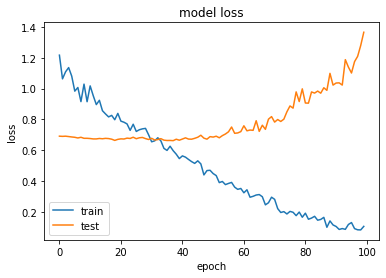

In [11]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()